In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings("ignore")

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Використовується пристрій: {device}")

Використовується пристрій: cuda


In [48]:
def get_data_loaders(batch_size=64):
    """Load CIFAR-10 dataset with data augmentation."""
    # Data augmentation for training
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    # No augmentation for testing
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train
    )
    trainloader = DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
    )

    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test
    )
    testloader = DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
    )

    return trainloader, testloader


In [49]:
trainloader, testloader = get_data_loaders(batch_size=64)

100%|██████████| 170M/170M [00:16<00:00, 10.3MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [50]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [51]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(InceptionBlock, self).__init__()

        # 1x1
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.BatchNorm2d(ch1x1),
            nn.ReLU(inplace=True)
        )

        # 1x1 -> 3x3
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.BatchNorm2d(ch3x3red),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ch3x3),
            nn.ReLU(inplace=True)
        )

        # 1x1 -> 5x5
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.BatchNorm2d(ch5x5red),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(ch5x5),
            nn.ReLU(inplace=True)
        )

        # 3x3 max pool -> 1x1
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], dim=1)

In [52]:
class AuxiliaryClassifier(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.avgpool = nn.AvgPool2d(5, stride=3)
        self.conv = nn.Conv2d(in_channels, 128, 1)
        self.relu = nn.ReLU(True)
        self.fc1 = nn.Linear(128 * 2 * 2, 1024)
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.avgpool(x)  # [B, C, ~2, ~2]
        x = self.conv(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)  # [B, 512]
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [53]:
class GoogLeNetCIFAR(nn.Module):
    def __init__(self, num_classes=10, use_aux=True):
        super().__init__()
        self.use_aux = use_aux

        self.pre = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(64, 64, 1), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.Conv2d(64, 192, 3, padding=1), nn.BatchNorm2d(192), nn.ReLU(True),
            nn.MaxPool2d(3, stride=2, padding=1)
        )

        self.a3 = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.b3 = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.b4 = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.c4 = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.d4 = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.e4 = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, padding=1)

        self.a5 = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.b5 = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

        if use_aux:
            self.aux1 = AuxiliaryClassifier(480, num_classes)  # після maxpool (3b)
            self.aux2 = AuxiliaryClassifier(512, num_classes)  # після b4
        else:
            self.aux1 = self.aux2 = None

    def forward(self, x):
        x = self.pre(x)
        x = self.a3(x)
        x = self.b3(x)
        x = self.maxpool(x)

        aux1 = self.aux1(x) if self.use_aux and self.training else None

        x = self.a4(x)
        x = self.b4(x)

        aux2 = self.aux2(x) if self.use_aux and self.training else None

        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)
        x = self.maxpool2(x)
        x = self.a5(x)
        x = self.b5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        if self.training and self.use_aux:
            return x, aux1, aux2
        return x

In [54]:
def train_model(model, trainloader, testloader, device, epochs=50, aux_weight=0.3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_acc = 0.0
    save_path = 'googlenet_cifar10_best.pth'

    print(f"Тренування на {epochs} епох...\n")

    for epoch in range(epochs):
        # TRAIN
        model.train()
        train_loss = train_correct = train_total = 0.0

        pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            if model.use_aux and model.training and isinstance(outputs, tuple):
                main_out, aux1, aux2 = outputs
                loss = criterion(main_out, labels) + aux_weight * (criterion(aux1, labels) + criterion(aux2, labels))
                pred = main_out
            else:
                loss = criterion(outputs, labels)
                pred = outputs

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = pred.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'loss': f'{train_loss/(pbar.n+1):.4f}',
                'acc': f'{100.*train_correct/train_total:.2f}%'
            })

        # VALIDATION
        model.eval()
        val_loss = val_correct = val_total = 0.0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                if isinstance(outputs, tuple): outputs = outputs[0]
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, pred = outputs.max(1)
                val_total += labels.size(0)
                val_correct += pred.eq(labels).sum().item()

        # МЕТРИКИ
        train_loss /= len(trainloader)
        train_acc = 100. * train_correct / train_total
        val_loss /= len(testloader)
        val_acc = 100. * val_correct / val_total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'\nEpoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f'  Best model saved (acc: {best_acc:.2f}%)')

        scheduler.step(val_loss)
        print()

    print(f"Тренування завершено! Найкраща точність: {best_acc:.2f}%")
    return history

In [55]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Val')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [56]:
def visualize_predictions(model, testloader, device, num_images=8):
    model.eval()
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        if isinstance(outputs, tuple): outputs = outputs[0]
        _, preds = torch.max(outputs, 1)

    images = images.cpu()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        img = images[i] / 2 + 0.5
        img = np.transpose(img.numpy(), (1, 2, 0))
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        color = 'green' if preds[i] == labels[i] else 'red'
        plt.title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}", color=color)
        plt.axis('off')
    plt.show()

In [60]:
model = GoogLeNetCIFAR(num_classes=10, use_aux=True).to(device)

In [61]:
history = train_model(model, trainloader, testloader, device, epochs=10)

Тренування на 10 епох...



Epoch 1/10: 100%|██████████| 782/782 [03:24<00:00,  3.82it/s, loss=3.0279, acc=31.23%]



Epoch 1/10:
  Train Loss: 3.0279, Train Acc: 31.23%
  Val Loss: 1.5469, Val Acc: 41.67%
  Best model saved (acc: 41.67%)



Epoch 2/10: 100%|██████████| 782/782 [04:12<00:00,  3.10it/s, loss=2.2110, acc=51.45%]



Epoch 2/10:
  Train Loss: 2.2110, Train Acc: 51.45%
  Val Loss: 1.2823, Val Acc: 53.25%
  Best model saved (acc: 53.25%)



Epoch 3/10: 100%|██████████| 782/782 [02:22<00:00,  5.47it/s, loss=1.8620, acc=60.29%]



Epoch 3/10:
  Train Loss: 1.8620, Train Acc: 60.29%
  Val Loss: 1.1924, Val Acc: 59.56%
  Best model saved (acc: 59.56%)



Epoch 4/10: 100%|██████████| 782/782 [02:04<00:00,  6.26it/s, loss=1.6958, acc=64.38%]



Epoch 4/10:
  Train Loss: 1.6958, Train Acc: 64.38%
  Val Loss: 1.0871, Val Acc: 60.98%
  Best model saved (acc: 60.98%)



Epoch 5/10: 100%|██████████| 782/782 [02:04<00:00,  6.28it/s, loss=1.5875, acc=67.03%]



Epoch 5/10:
  Train Loss: 1.5875, Train Acc: 67.03%
  Val Loss: 1.0710, Val Acc: 64.69%
  Best model saved (acc: 64.69%)



Epoch 6/10: 100%|██████████| 782/782 [02:04<00:00,  6.29it/s, loss=1.5172, acc=68.90%]



Epoch 6/10:
  Train Loss: 1.5172, Train Acc: 68.90%
  Val Loss: 1.1653, Val Acc: 60.54%



Epoch 7/10: 100%|██████████| 782/782 [02:04<00:00,  6.28it/s, loss=1.4388, acc=70.88%]



Epoch 7/10:
  Train Loss: 1.4388, Train Acc: 70.88%
  Val Loss: 1.2660, Val Acc: 59.55%



Epoch 8/10: 100%|██████████| 782/782 [02:03<00:00,  6.33it/s, loss=1.3772, acc=72.24%]



Epoch 8/10:
  Train Loss: 1.3772, Train Acc: 72.24%
  Val Loss: 1.1999, Val Acc: 62.34%



Epoch 9/10: 100%|██████████| 782/782 [02:03<00:00,  6.33it/s, loss=1.3072, acc=73.71%]



Epoch 9/10:
  Train Loss: 1.3072, Train Acc: 73.71%
  Val Loss: 1.2394, Val Acc: 59.79%



Epoch 10/10: 100%|██████████| 782/782 [02:02<00:00,  6.38it/s, loss=1.2536, acc=74.86%]



Epoch 10/10:
  Train Loss: 1.2536, Train Acc: 74.86%
  Val Loss: 0.8128, Val Acc: 73.37%
  Best model saved (acc: 73.37%)

Тренування завершено! Найкраща точність: 73.37%


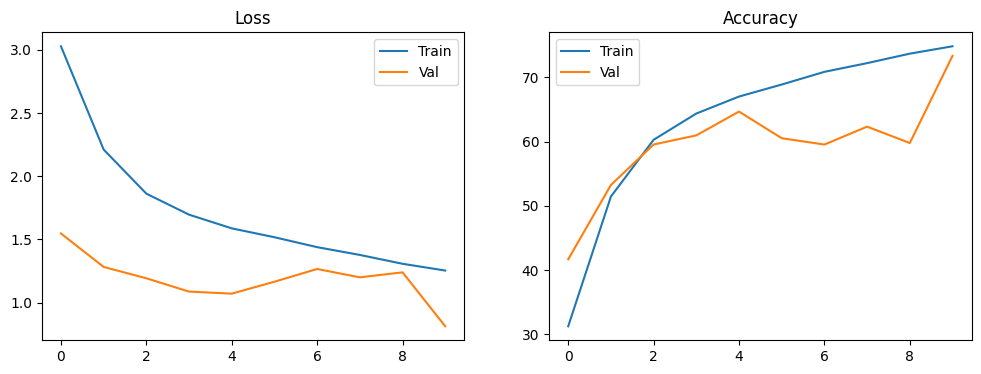

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5885309..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7988244].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.675763..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38462442..1.6720076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6466857..1.4542255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6697937..1.330576].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.704840

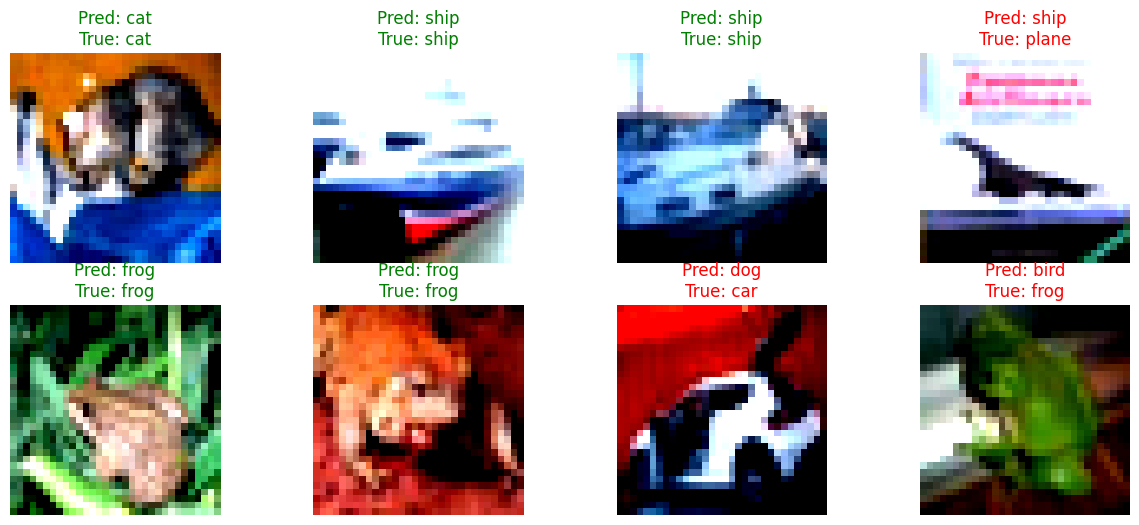

In [62]:
plot_history(history)
visualize_predictions(model, testloader, device)

In [63]:
model.load_state_dict(torch.load('googlenet_cifar10_best.pth'))

<All keys matched successfully>